# ANALYZING BIOLOGICAL NETWORKS WITH ANTIMONY AND TELLURIUM

In [2]:
# Preliminaries
!pip install -q tellurium
import tellurium as te
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Antimony Modeling Language

A **Chemical Reaction Network (CRN)** describes a system of interacting reactions that consume and produce chemical species.

Antimony is a computer language that describes and simulates chemical reaction networks. The core elements are:
* **species** that represent chemical entities
* **reactions** that represent the transform of reactant species into product species
* **parameters** that are constants used in describing reaction rates and initial values of species concentrations

An example of Antimony reaction is ``J0: O2 + 2 H2 -> 2 H2O; k*O2*H2*H2``. The expression after the semicolon (';') is the **rate law** for
the reaction that describes how fast (**reaction flux**) ``O2`` and ``2 H2`` are converted to ``2 H2O``. ``J0`` is the reaction name (optional).

In general, the syntax for defining a reaction in Antimony is to list the species being consumed, separated by a +, followed by an arrow ->, followed by another list of species being created, followed by a semicolon and a mathematical expression.

Antimony networks are interpreted and simulated by ``tellurium``, a ``pip`` installable library. The Antimony model is a python string.

# Tellurium essentials

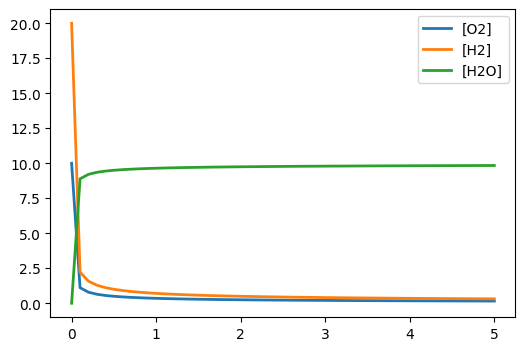

In [44]:
model1 = """
J0: O2 + 2 H2 -> H2O; k*O2*H2*H2

O2 = 10
H2 = 20
H2O = 0
k = 1
"""
rr = te.loada(model1)
rr.simulate()
rr.plot()

The ``simulate`` method can be used to produce an array that we separately interrogate and/or manipulate.

In [50]:
model1 = """
J0: O2 + 2 H2 -> H2O; k*O2*H2*H2

O2 = 10
H2 = 20
H2O = 0
k = 1
"""
rr = te.loada(model1)
#data = rr.simulate()
#data

**Question**
Extract the data for steady state.

## Reading and writing values of tellurium variables

We sometimes need to read or modify species concentrations or parameter values in ``tellurium``. This can be done by treating the roadrunner object (typically ``rr``) as a dictionary.

In [34]:
print(rr['k1'])

1.0


In [35]:
rr['k1'] = 2
print(rr['k1'])

2.0


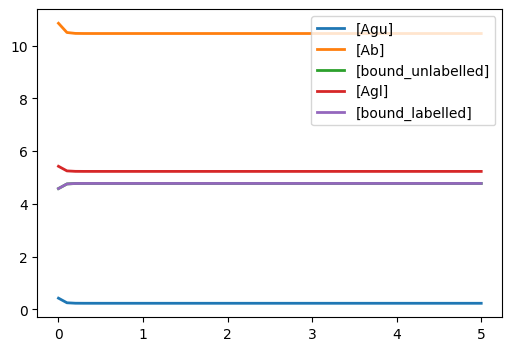

In [36]:
# If you simulate with the updated value, you get different results than before.
rr.simulate()
rr.plot()

## Controlling simulation output

We can control the time granularity of the simulation and the variables that are produced by using arguments to ``simulate``. For example,
``simulate(start_time, end_time, num_point, ['var1', 'var2'])``

In [48]:
model2 = """
J0: O2 + 2 H2 -> H2O; k*O2*H2*H2

$O2 = 10
$H2 = 20
H2O = 0
k = 1
"""
rr = te.loada(model2)
data = rr.simulate(3, 5, 20, ['time', 'O2', 'H2O'])
data

       time, O2,     H2O
 [[       3, 10,       0],
  [ 3.10526, 10, 421.053],
  [ 3.21053, 10, 842.105],
  [ 3.31579, 10, 1263.16],
  [ 3.42105, 10, 1684.21],
  [ 3.52632, 10, 2105.26],
  [ 3.63158, 10, 2526.32],
  [ 3.73684, 10, 2947.37],
  [ 3.84211, 10, 3368.42],
  [ 3.94737, 10, 3789.47],
  [ 4.05263, 10, 4210.53],
  [ 4.15789, 10, 4631.58],
  [ 4.26316, 10, 5052.63],
  [ 4.36842, 10, 5473.68],
  [ 4.47368, 10, 5894.74],
  [ 4.57895, 10, 6315.79],
  [ 4.68421, 10, 6736.84],
  [ 4.78947, 10, 7157.89],
  [ 4.89474, 10, 7578.95],
  [       5, 10,    8000]]

**Fixed species** (**boundary species**) are chemical species whose values do not change (e.g.,. regulated by a chemostat). They are indicated by prefacing the symbol by a ``$``.

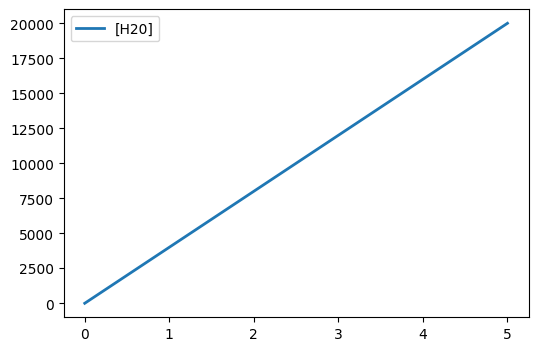

In [8]:
model2 = """
J0: O2 + 2 H2 -> H20; k*O2*H2*H2

$O2 = 10
$H2 = 20
H20 = 0
k = 1
"""
rr = te.loada(model2)
rr.simulate()
rr.plot()

Fix species are not reported by default.

**Question**

Write a python function that reports the time at which the concentration of ``H2O`` changes by less than 1 percent.

### Answer

In [30]:
def findStationarity(model:str, species:str, max_time:float=100)->float:
    """
    Determines the time, if any, at which species changes by no more than 1 percent. Assumes that rate of change is decreasing.
    
    Args:
        model: Antimony model
        species: Chemical species (without '[' ']')
        max_time: seconds
    """
    rr = te.loada(model)
    num_point = max_time*1000
    data = rr.simulate(0, max_time, num_point, ['time', "[" + species + "]"])
    values = data[:, 1]
    diff_values = np.diff(values)
    idxs = np.array(diff_values < 0.01)
    times = np.array(data[1:, 1])
    stable_values = times[idxs]
    return stable_values[0]

# Tests
assert(findStationarity(model1, "H2O", 100) > 8.0)
print("OK!")
    

OK!


## Finding steady state for a model

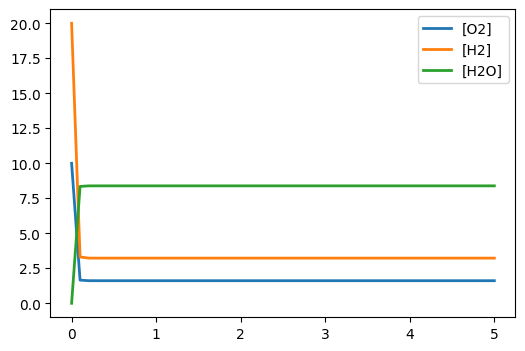

In [58]:
model3 = """
J0: O2 + 2 H2 -> H2O; k1*O2*H2*H2
J1: H2O -> O2 + 2 H2; k2*H2O

O2 = 10
H2 = 20
H2O = 0
k1 = 1
k2 = 2
"""
rr = te.loada(model3)
rr.simulate()
rr.plot()

In [56]:
rr.steadyState()

0.0

In [57]:
rr.H2O

8.38737976860411

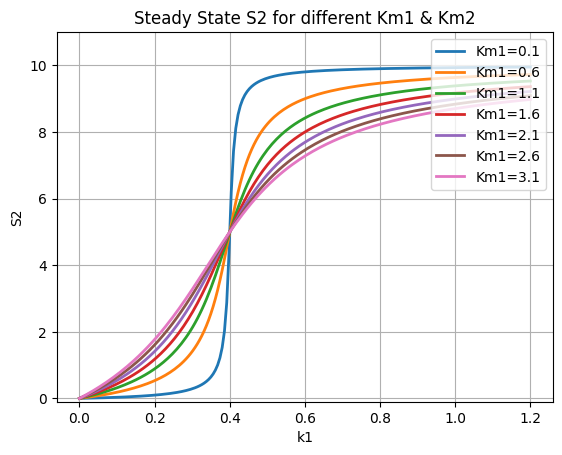

In [74]:
# An elaborate example of using steadyState
r = te.loada ('''
   S1 -> S2; k1*S1/(Km1 + S1);
   S2 -> S1; k2*S2/(Km2 + S2);

   k1 = 0.1; k2 = 0.4; S1 = 10; S2 = 0;
   Km1 = 0.1; Km2 = 0.1;
''')

r.conservedMoietyAnalysis = True

for i in range (1,8):
  numbers = np.linspace (0, 1.2, 200)
  result = np.empty ([0,2])
  for value in numbers:
      r.k1 = value
      r.steadyState()
      row = np.array ([value, r.S2])
      result = np.vstack ((result, row))
  te.plotArray(result, show=False, labels=['Km1={}'.format(r.Km1)],
               resetColorCycle=False,
               xlabel='k1', ylabel="S2",
               title="Steady State S2 for different Km1 & Km2",
               ylim=[-0.1, 11], grid=True)
  r.k1 = 0.1
  r.Km1 = r.Km1 + 0.5;
  r.Km2 = r.Km2 + 0.5;
plt.show()

## A glycolysis model

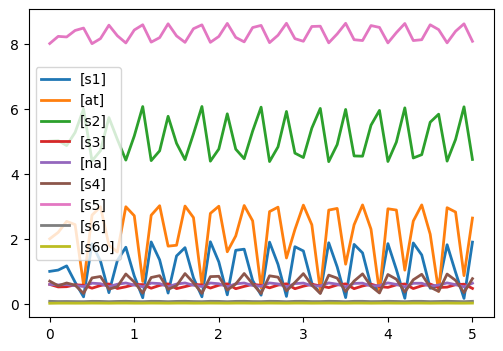

In [77]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml"
rr = te.loadSBMLModel(URL)
rr.simulate()
rr.plot()

In [78]:
print(rr.getAntimony())

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

### Plotting with matplotlib

# Radio Immunoassays

Antibodies are proteins with very high affinities to specific molecules called antigens. Because of their specificity,
antibodies can be used to get very precise assays. One approach is radioimmunoassay (RIA).

The principle of RIA involves competitive binding of radiolabeled antigen and unlabeled antigen to a high-affinity antibody. The labeled antigen is mixed with antibody at a concentration that saturates the antigen-binding sites of the antibody. Then test samples of unlabeled antigen of unknown concentration are added in progressively larger amounts. The antibody does not distinguish labeled from unlabeled antigen, so the two kinds of antigen compete for available binding sites on the antibody. As the concentration of unlabeled antigen increases, more labeled antigen will be displaced from the binding sites. The decrease in the amount of radiolabeled antigen bound to specific antibody in the presence of the test sample is measured in order to determine the amount of antigen present in the test sample.

In this problem, you will:
1. Write an Antimony reaction network for the interactions between an antibody and its labelled and unlabelled antigen
1. Write a python function that calculates the amount of bound, labelled antigen at steady state as the amount of we increase the total amount of unlabelled antigen.
1. Write a python function that plots a curve that relates the amount of bound, labelled antigen to the amount of unlabelled antigen for a fixed concentration of the antibody.

To simplify matters, use mass action kinetics in which all kinetic constants are 1.

## Antimony Model

Let ``Agu` be the unlabelled antigen and ``Agl`` be the labelled antigen. ``Ab`` is the antibody.

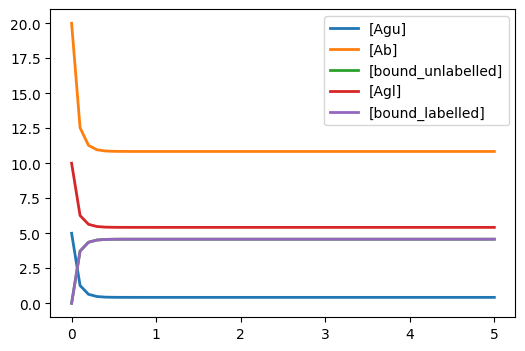

In [62]:
antibody_model = """
Agu + Ab -> bound_unlabelled; k1*Agu*Ab
Agl + Ab -> bound_labelled; k1*Agu*Ab
bound_unlabelled -> Agu + Ab; k2*bound_unlabelled
bound_labelled -> Agl + Ab; k2*bound_labelled

Agu = 5
Agl = 10
Ab = 20
k1 = 1
k2 = 1
"""
rr = te.loada(antibody_model)
rr.simulate()
rr.plot()

## Evaluation of Antimony Model

In [70]:
def calculateBoundLabelledAntigen(Agu:float)->float:
    """
    Calculate the amount of bound labelled antigen at steady state given an amount of unlabelled antigen.
    
    Args:
        Agu: Unlabelled antigen
    """
    rr = te.loada(antibody_model)
    rr['Agu'] = Agu
    rr.steadyState()
    return rr.bound_labelled

# Tests
calculateBoundLabelledAntigen(20)

4.577855614887629

## Python Function